The mathmatical approcah form the book Machine Learning (Zhi-Hua Zhou)

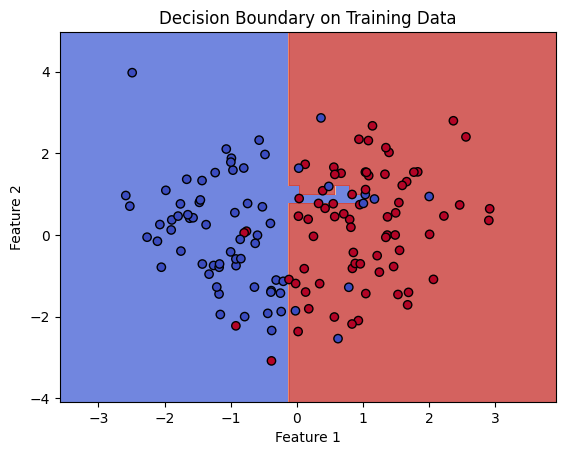

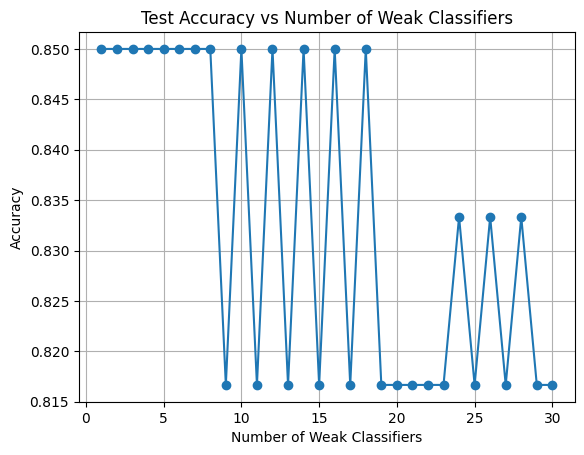

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class WeakClassifier:
    def __init__(self):
        self.threshold = None
        self.feature_index = None
        self.polarity = 1

    def fit(self, X, y, weights):
        n_samples, n_features = X.shape
        self.error = float('inf')

        for feature_i in range(n_features):
            feature_values = X[:, feature_i]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = np.ones_like(y)
                    predictions[feature_values * polarity < threshold * polarity] = -1
                    error = np.sum(weights * (predictions != y))

                    if error < self.error:
                        self.threshold = threshold
                        self.feature_index = feature_i
                        self.polarity = polarity
                        self.error = error

    def predict(self, X):
        feature_values = X[:, self.feature_index]
        predictions = np.ones(X.shape[0])
        predictions[feature_values * self.polarity < self.threshold * self.polarity] = -1
        return predictions

class AdaBoost:
    def __init__(self, base_learner, n_estimators):
        self.base_learner = base_learner
        self.n_estimators = n_estimators
        self.alpha = []
        self.weak_classifiers = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for t in range(self.n_estimators):
            weak_clf = self.base_learner()
            weak_clf.fit(X, y, weights)
            predictions = weak_clf.predict(X)

            error = np.sum(weights * (predictions != y)) / np.sum(weights)
            if error > 0.5:
                break

            alpha_t = 0.5 * np.log((1 - error) / (error + 1e-10))
            self.alpha.append(alpha_t)
            self.weak_classifiers.append(weak_clf)

            weights *= np.exp(-alpha_t * y * predictions)
            weights /= np.sum(weights)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for alpha_t, weak_clf in zip(self.alpha, self.weak_classifiers):
            final_predictions += alpha_t * weak_clf.predict(X)
        return np.sign(final_predictions)

# 数据可视化工具
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# 主程序
if __name__ == "__main__":
    # 生成数据
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=42)
    y = np.where(y == 0, -1, 1)

    # 划分训练集和测试集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 初始化并训练 AdaBoost
    n_estimators = 30
    adaboost = AdaBoost(base_learner=WeakClassifier, n_estimators=n_estimators)
    adaboost.fit(X_train, y_train)

    # 绘制决策边界
    plot_decision_boundary(adaboost, X_train, y_train, title="Decision Boundary on Training Data")

    # 测试集准确率随弱分类器数量的变化
    test_accuracies = []
    for t in range(1, n_estimators + 1):
        # 限制使用 t 个弱分类器
        partial_model = AdaBoost(base_learner=WeakClassifier, n_estimators=t)
        partial_model.weak_classifiers = adaboost.weak_classifiers[:t]
        partial_model.alpha = adaboost.alpha[:t]
        y_pred = partial_model.predict(X_test)
        test_accuracies.append(np.mean(y_pred == y_test))

    # 绘制测试集准确率曲线
    plt.plot(range(1, n_estimators + 1), test_accuracies, marker='o')
    plt.title("Test Accuracy vs Number of Weak Classifiers")
    plt.xlabel("Number of Weak Classifiers")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


Vrification Approach that's done based on sklearn

[调库] 训练集准确率: 99.25%
[调库] 测试集准确率: 96.83%


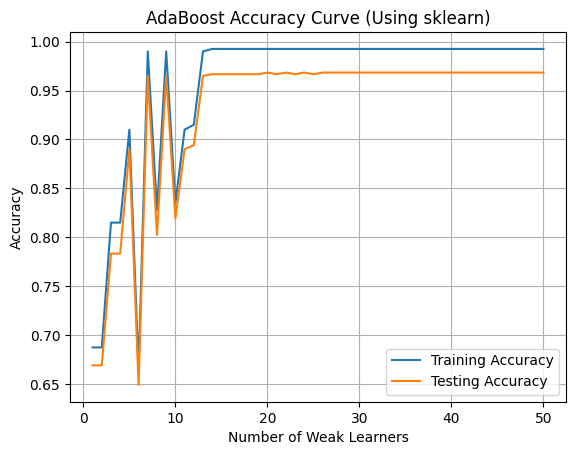

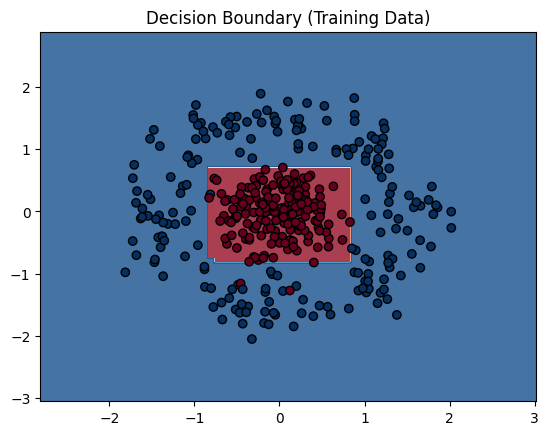

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# --- 数据加载 ---
# 加载提供的训练数据和测试数据
train_data = np.loadtxt("adaboost-train-24.txt")
test_data = np.loadtxt("adaboost-test-24.txt")

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# --- 用调库实现 AdaBoost ---
# 使用决策树（深度为1）作为弱学习器
weak_learner = DecisionTreeClassifier(max_depth=1)

# 创建 AdaBoost 模型
n_estimators = 50  # 弱学习器的数量
model = AdaBoostClassifier(estimator=weak_learner, n_estimators=n_estimators, algorithm="SAMME")

# 训练模型
model.fit(X_train, y_train)

# --- 测试性能 ---
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"[调库] 训练集准确率: {train_accuracy * 100:.2f}%")
print(f"[调库] 测试集准确率: {test_accuracy * 100:.2f}%")

# --- 准确率曲线 ---
train_accuracies = []
test_accuracies = []

for i, pred in enumerate(model.staged_predict(X_train)):
    train_accuracies.append(accuracy_score(y_train, pred))

for i, pred in enumerate(model.staged_predict(X_test)):
    test_accuracies.append(accuracy_score(y_test, pred))

# --- 绘图 ---
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Testing Accuracy")
plt.xlabel("Number of Weak Learners")
plt.ylabel("Accuracy")
plt.title("AdaBoost Accuracy Curve (Using sklearn)")
plt.legend()
plt.grid()
plt.show()

# --- 可视化决策边界 ---
# 为了可视化，我们需要降维到2D（确保数据本身是二维的）
if X_train.shape[1] == 2:
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.RdBu)
    plt.title("Decision Boundary (Training Data)")
    plt.show()
else:
    print("[可视化] 数据维度不是2D，无法绘制决策边界。")